In [1]:
import tensorflow as tf
import optuna
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [3]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[column]>num][column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
        indicator.append(1 if len(arr[arr>i]) else 0)
    return time, indicator

In [ ]:
columns = ['bid_prices_0',	'ask_prices_0',	'bid_prices_1',	'ask_prices_1',	'bid_prices_2', 'bid_prices_3',	'ask_prices_3','bid_prices_4',	'ask_prices_4']
for column in columns:
  df['time_'+column], _ =  finder_of_fulfilment(df, column)

In [ ]:
def plot_KM_estimator(column):
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),2)
  df_to_plot = df['time_'+column]
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df_to_plot[df_to_plot['time_'+column]==time])
      num_survived = len(df_to_plot[df_to_plot['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)
      S_hat = np.cumprod(S_of_t)
      t = times[:400]

      plt.figure(figsize=(6, 6))
      plt.plot(t, S_hat[:400], linewidth=2, label='Level 1, pegged', color='black')
      plt.xlabel('t (sec.)')
      plt.ylabel('$\hat{S}(t)$')
      plt.title('Survival Probability Over Time')
      plt.legend()
      plt.grid(True)
      plt.show()

In [ ]:
for column in columns:
  plot_KM_estimator(column)

In [9]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

Vol is 0.16% per second
Vol is 9.83% per hour
Vol is 48.13% per day
Vol is 919.93% per year


In [10]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

In [11]:
target = [] #create target S(execution_time)
for i in range(len(df)):
    target.append(S_of_t[df['time'].iloc[i]-1])

df['target'] = target

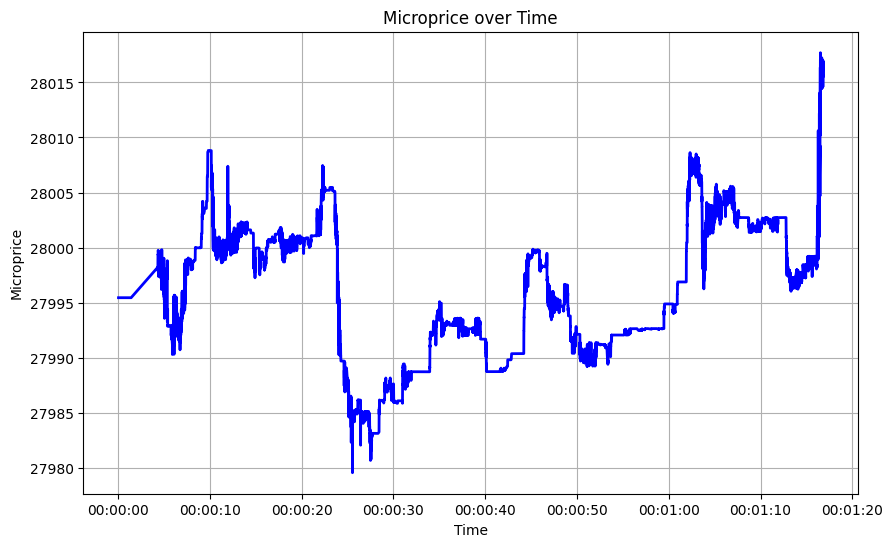

In [12]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

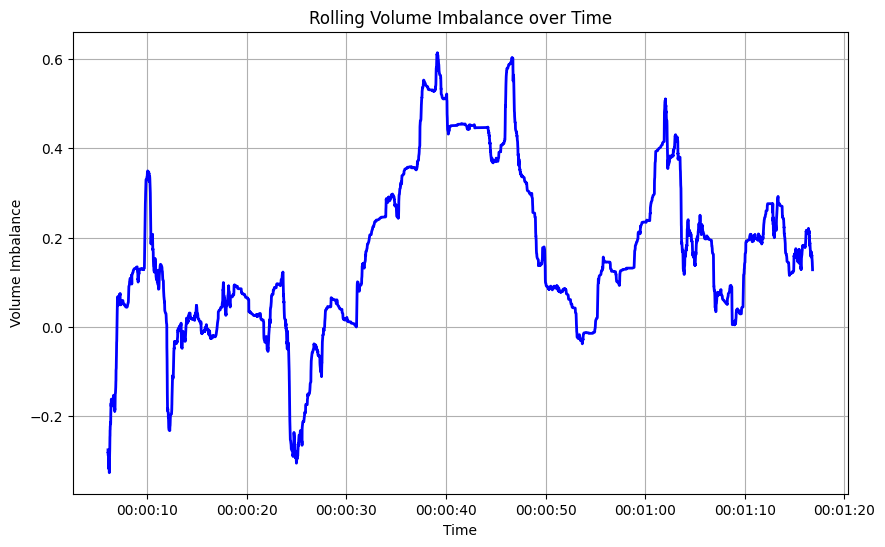

In [13]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

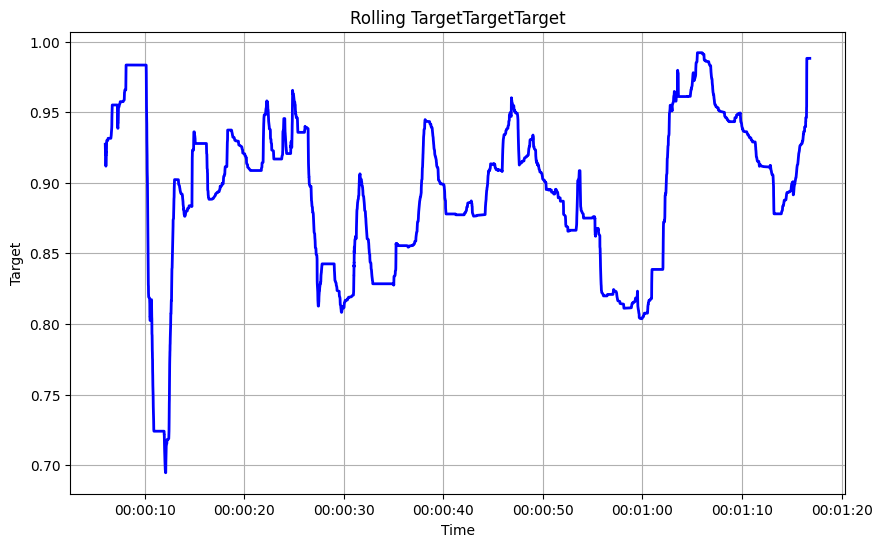

In [14]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['target'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Target thing')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Rolling TargetTargetTarget')

# Displaying the grid
plt.grid(True)

In [ ]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

In [ ]:
df.dropna(inplace=True)
df.describe()

In [24]:
#df.set_index('timestamp', drop=True, inplace=True)
N = 100 # define the number of previous observations included

X = df.drop(columns=['timestamp', 'time', 'indicator', 'target'])
Y = df['time'].iloc[N:len(X)].values
print(Y.shape)

(18402,)


In [25]:
#Y = Y[1:]

In [26]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

print(X.shape)

(18402, 101, 23)


In [20]:
input_shape = (N+1, 23, 1)
encoder_input = layers.Input(shape=input_shape)

# Encoder
encoder_conv1 = layers.Conv1D(4, kernel_size=2, activation='relu', padding='causal')(encoder_input)
encoder_conv2 = layers.Conv1D(4, kernel_size=2, activation='relu', padding='causal')(encoder_conv1)
encoder_flatten = layers.Flatten()(encoder_conv2)
latent_dim = 4
encoder_output = layers.Dense(latent_dim, activation='relu')(encoder_flatten)

encoder_model = Model(encoder_input, encoder_output)

# Decoder
decoder_input = layers.Input(shape=(latent_dim,))
# Compute the shape after the last conv layer before flattening
shape_before_flattening = encoder_conv2.shape[1:]
decoder_dense1 = layers.Dense(np.prod(shape_before_flattening), activation='relu')(decoder_input)
decoder_reshape = layers.Reshape(shape_before_flattening)(decoder_dense1)
decoder_conv1 = layers.Conv1DTranspose(4, kernel_size=2, activation='relu', padding='causal')(decoder_reshape)
decoder_conv2 = layers.Conv1DTranspose(4, kernel_size=2, activation='relu', padding='causal')(decoder_conv1)
decoder_flatten = layers.Flatten()(decoder_conv2)
decoder_output = layers.Dense(1, activation='relu')(decoder_flatten)  # Adjust based on the shape of Y

decoder_model = Model(decoder_input, decoder_output)

# Autoencoder
autoencoder_input = layers.Input(shape=input_shape)
encoded = encoder_model(autoencoder_input)
decoded = decoder_model(encoded)
autoencoder_model = Model(autoencoder_input, decoded)

autoencoder_model.compile(optimizer='adam', loss='MAE')

# Reshape X to include the channel dimension
X_reshaped = np.expand_dims(X, axis=-1)

# Fit the model to X and Y
autoencoder_model.fit(X_reshaped, Y, epochs=3, batch_size=16)

ValueError: ignored

# Simplified Staff (LSTM instead of Att)

In [ ]:
Y_pred = autoencoder_model.predict(X)

In [ ]:
(Y_pred)

# Some experiements (model is almost ready monotonicity change is needed or S(t) to f(t) transition)

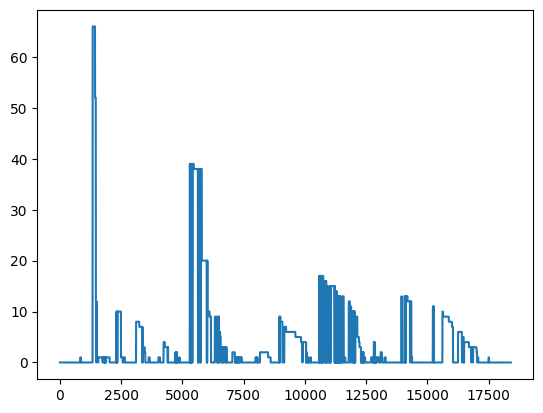

In [27]:
plt.plot(Y)

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, units, dilation_rate):
        super(Encoder, self).__init__()
        self.units = units
        self.dilation_rate = dilation_rate

        # Dilated Convolution layer
        self.dilated_conv = tf.keras.layers.Conv1D(filters=filters,
                                                   kernel_size=kernel_size,
                                                   dilation_rate=self.dilation_rate,
                                                   padding='causal',
                                                   activation='relu')

        # Multi-Head Attention layer with 3 heads
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=16)

        # Flatten layer to reduce to a one-dimensional array
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x):
        # Dilated Convolution
        x = self.dilated_conv(x)

        # Multi-Head Attention
        attention_output = self.multi_head_attention(x, x)
        x = attention_output + x  # Residual connection

        # Flatten the output
        x = self.flatten(x)

        return x

class SimpleDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers=10, units_per_layer=64, activation='relu', l1_reg=0.1, dropout_rate=0.1):
        super(SimpleDecoder, self).__init__()
        self.num_layers = num_layers
        self.units_per_layer = units_per_layer
        self.activation = activation
        self.l1_reg = l1_reg
        self.dropout_rate = dropout_rate

        # Initialize dense layers with L1 regularization and Dropout layers
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(layers.Dense(units=self.units_per_layer,
                                            activation=self.activation,
                                            kernel_regularizer=regularizers.l1(self.l1_reg)))
            self.layers.append(layers.Dropout(self.dropout_rate))

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)  # Only apply dropout during training
            else:
                x = layer(x)
        return x

def create_encoder(input_shape, d_model, num_heads, dilation_rate):
    return Encoder(units=d_model, filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate)

# Combine the encoder and decoder to create the full model
def create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = create_encoder(input_shape, d_model, num_heads, filters)
    encoder_output = encoder(encoder_inputs)

    decoder = SimpleDecoder()
    decoder_output = decoder(encoder_output)

    # Flatten the decoder output if not already flattened
    flat_output = tf.keras.layers.Flatten()(encoder_output)
    output = tf.keras.layers.Dense(output_shape)(flat_output)
    abs_out = tf.keras.layers.Lambda(lambda x: abs(x))(output)
    full_model = tf.keras.models.Model(inputs=encoder_inputs, outputs=abs_out)

    return full_model

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
filters = 2
units = 4
kernel_size = 2
num_heads = 3
d_model = 2
output_shape = 1
batch = 16 # to determine
# Create the model
model = create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=10**(-4)),
              loss='mse')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(x=X, y=Y, batch_size=batch, epochs=100, callbacks=[callback])

In [ ]:
Y_pred = model.predict(X)

plt.plot(Y_pred)

In [31]:
# Define model parameters
input_shape = (N+1, 23)
num_heads = 3
output_shape = 1

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    filters = trial.suggest_categorical('filters', [2, 4, 8, 16])
    units = trial.suggest_categorical('units', [1, 4, 8, 16, 32])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5, 7])
    dilation_rate = trial.suggest_categorical('dilation_rate', [1, 2, 3, 4])
    d_model = trial.suggest_categorical('d_model', [1, 2, 4, 8, 32])
    batch = trial.suggest_categorical('batch', [4, 8, 16, 32])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-1])  # Suggest learning rate

    # Create the model using the suggested values
    model = create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),loss='mse')

    train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size = batch)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(train_ds, epochs=50, callbacks=[callback], verbose=1)

    val_loss = sum(history.history['loss'][-6:-1])/5
    return val_loss

# Optuna study
study = optuna.create_study(direction='minimize')  # 'minimize' if lower loss is better, 'maximize' otherwise
study.optimize(objective, n_trials=50)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = 1
num_heads = 3
filters = trial.params['filters']
units = trial.params['units']
kernel_size = trial.params['kernel_size']
d_model = trial.params['d_model']
batch = trial.params['batch']
learning_rate = trial.params['learning_rate']
# Create the model
model = create_full_model(input_shape, filters, kernel_size, num_heads, d_model, output_shape, units)

# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size=batch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='mse')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.fit(train_ds, epochs=100, callbacks=[callback])

In [ ]:
Y_pred = model.predict(X)

In [ ]:
plt.plot(Y_pred)
plt.plot(Y)

In [ ]:
model = cb.CatBoostRegressor(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    loss_function='RMSE'
)